In [1]:
import pandas as pd
import numpy as np
import gensim as gs
import simplejson as json
import matplotlib.pyplot as plt

import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import defaultdict
# from nltk import RegexpTokenizer

%matplotlib inline

E:\AppData\Local\Continuum\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


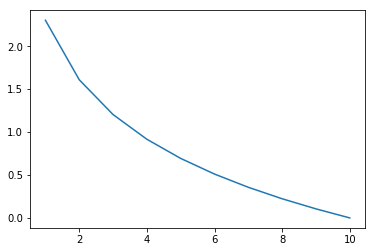

In [2]:
def idf(x):
    return np.log(10/x)

x = np.linspace(1,10,num=10)
plt.plot(x,idf(x))
plt.show()

In [3]:
class PreprocessIMDBData:
    def __init__(self):
        self.pattern = "[\w]+"
        self.stopword_set = set(stopwords.words('english'))
        
    def tokenizeSentence(self,text):
        tokenized_sentence = [w.lower() for w in nltk.regexp_tokenize(text,self.pattern)]
        cleanedSentence = list(set(tokenized_sentence).difference(self.stopword_set))
        return cleanedSentence

In [4]:
class VectorizeIMDBData:
    
    def __init__(self,tokenizerObj = PreprocessIMDBData()):
        self.tokenizerObj = tokenizerObj 
        self.tfidf = TfidfVectorizer(tokenizer=tokenizerObj.tokenizeSentence, ngram_range=(0, 1))
    
    def getTFIDFMatrix(self,docs):
        return self.tfidf.fit_transform(docs),self.tfidf.vocabulary_
    
    def getCleanedDocuments(self,docs, threshold = 0.6):
        scores,vocab = self.getTFIDFMatrix(docs)
        idf_inverse = 1/self.tfidf.idf_
        new_vocab_keys = (idf_inverse <= threshold)
        
        new_docs = []
        for doc_id,document in enumerate(docs):
            new_doc = []
            words = self.tokenizerObj.tokenizeSentence(document)
            for word in words:
                word_id  = vocab.get(word)
                if word_id is not None and new_vocab_keys[word_id]:
                    new_doc.append(word)
            
            cleanedDocument = ' '.join(new_doc)
            new_docs.append(cleanedDocument)
            
            del new_doc
        return new_docs
    
    def plot_words(self,threshold = [0.6]):
        max_figs_in_row = 5
        rows = int(np.ceil(len(threshold)/max_figs_in_row))
        cols  = np.minimum(len(threshold),max_figs_in_row)
        
        fig, axes = plt.subplots(rows, cols, figsize = (15, 9))
        
        vocab = self.tfidf.vocabulary_
        idf_inverse = 1/self.tfidf.idf_
        
        for i, ax in enumerate(fig.axes):
            frequencies = {}
            for key,value in vocab.items():
                if  value < len(idf_inverse) and idf_inverse[value] <= threshold[i]:
                    frequencies[key] = idf_inverse[value]
            
            if len(frequencies) <= 0:
                continue
            
            wc  = WordCloud(max_words=100)
            wc.generate_from_frequencies(frequencies)
            ax.imshow(wc, interpolation='bilinear')
            ax.set_axis_off()
        return

In [5]:
mytokenizer = PreprocessIMDBData()
myTfIdfGenerator = VectorizeIMDBData(mytokenizer)

                                            #################  Test tf-idf and tokenizer
# docs = ["The sun is shining allowance", "The sun weather is sweet", "the is shining and the weather is sweet"]
# cleaned_docs = myTfIdfGenerator.getCleanedDocuments(docs,threshold=0.8)
# print(cleaned_docs)

In [6]:
movies_actual = pd.read_csv('./the-movies-dataset/movies_metadata.csv',low_memory=False)
cols = ['id','title','genres','overview']
movies_df_clean = movies_actual[cols]
movies_df_clean = movies_df_clean[pd.notnull(movies_df_clean['overview'])]
movies_df_clean.info()
del movies_actual

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44512 entries, 0 to 45465
Data columns (total 4 columns):
id          44512 non-null object
title       44506 non-null object
genres      44512 non-null object
overview    44512 non-null object
dtypes: object(4)
memory usage: 1.7+ MB


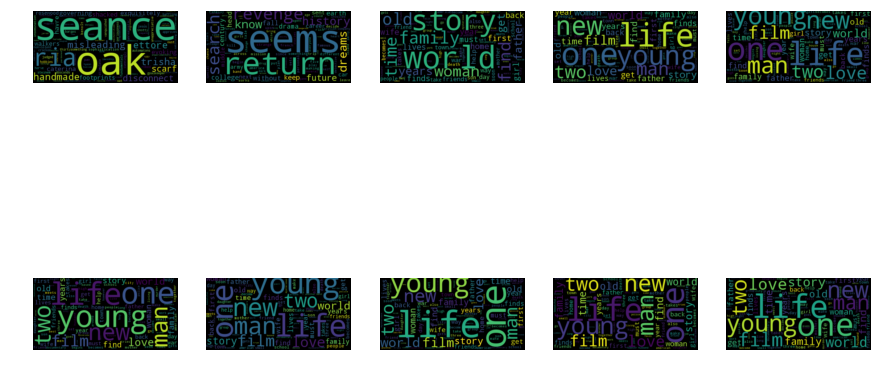

In [7]:
myTfIdfGenerator.getTFIDFMatrix(docs=list(movies_df_clean['overview']))
myTfIdfGenerator.plot_words(threshold=np.linspace(0.1,0.99,num=10))

In [8]:
overview_cleaned = myTfIdfGenerator.getCleanedDocuments(list(movies_df_clean['overview']), threshold = 0.6)
movies_df_clean['overview_cleaned'] = overview_cleaned

In [9]:
def plot_frequencies(movies_df_clean,cutoff = 0.00000001,columnName = 'overview',showGraph = False):
    mytokenizer = PreprocessIMDBData()
    genre_unkw = {}
    for index,row in movies_df_clean.iterrows():
        genresStr = row['genres']
        if pd.isnull(genresStr ):
            continue
        genreJson = json.loads(genresStr.replace("'",'"'))
        
        summary = set(mytokenizer.tokenizeSentence(row[columnName]))
        if len(summary) <= 0:
            continue
        
        for genreObject in genreJson:
            uniqueWords = set()
            if genreObject['name']  in genre_unkw:
                uniqueWords = genre_unkw[genreObject['name']]
            
            uniqueWords |= summary
            genre_unkw[genreObject['name']] = uniqueWords
            
    uniqueWordsSet = set()    
    uniqueWordsDict = {}
    for genre,uniqueWords in genre_unkw.items():
        uniqueGenreRep_Count = len(uniqueWords)
        uniqueWordsSet |= uniqueWords
        if uniqueGenreRep_Count <= cutoff * len(movies_df_clean):
            continue
        
        uniqueWordsDict[genre] = uniqueGenreRep_Count
        uniqueWordsDict['VocabSize'] = len(uniqueWordsSet)
        
    df = pd.DataFrame.from_dict(uniqueWordsDict, orient='index')
    if showGraph:
        df.plot(kind='bar')
    
    del uniqueWordsDict
    del genre_unkw
    return df

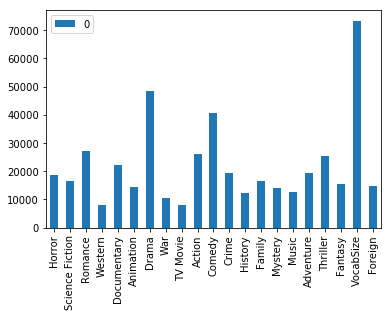

In [10]:
df = plot_frequencies(movies_df_clean,cutoff = 0.1,showGraph=True)

In [11]:
thresholds=np.linspace(0.1,0.99,num=10)

plots_list = list()
for threshold in thresholds:
    print("Analyzing for threshold ",threshold)
    overview_cleaned = myTfIdfGenerator.getCleanedDocuments(list(movies_df_clean['overview']), threshold = threshold)
    movies_df_clean['overview_cleaned'] = overview_cleaned
    df = plot_frequencies(movies_df_clean,cutoff=0.1,columnName='overview_cleaned')
    plots_list.append(df)
    print("Done with analysis")
print("------------->Done<-------------")

Analyzing for threshold  0.1
Done with analysis
Analyzing for threshold  0.198888888889
Done with analysis
Analyzing for threshold  0.297777777778
Done with analysis
Analyzing for threshold  0.396666666667
Done with analysis
Analyzing for threshold  0.495555555556
Done with analysis
Analyzing for threshold  0.594444444444
Done with analysis
Analyzing for threshold  0.693333333333
Done with analysis
Analyzing for threshold  0.792222222222
Done with analysis
Analyzing for threshold  0.891111111111
Done with analysis
Analyzing for threshold  0.99
Done with analysis
------------->Done<-------------


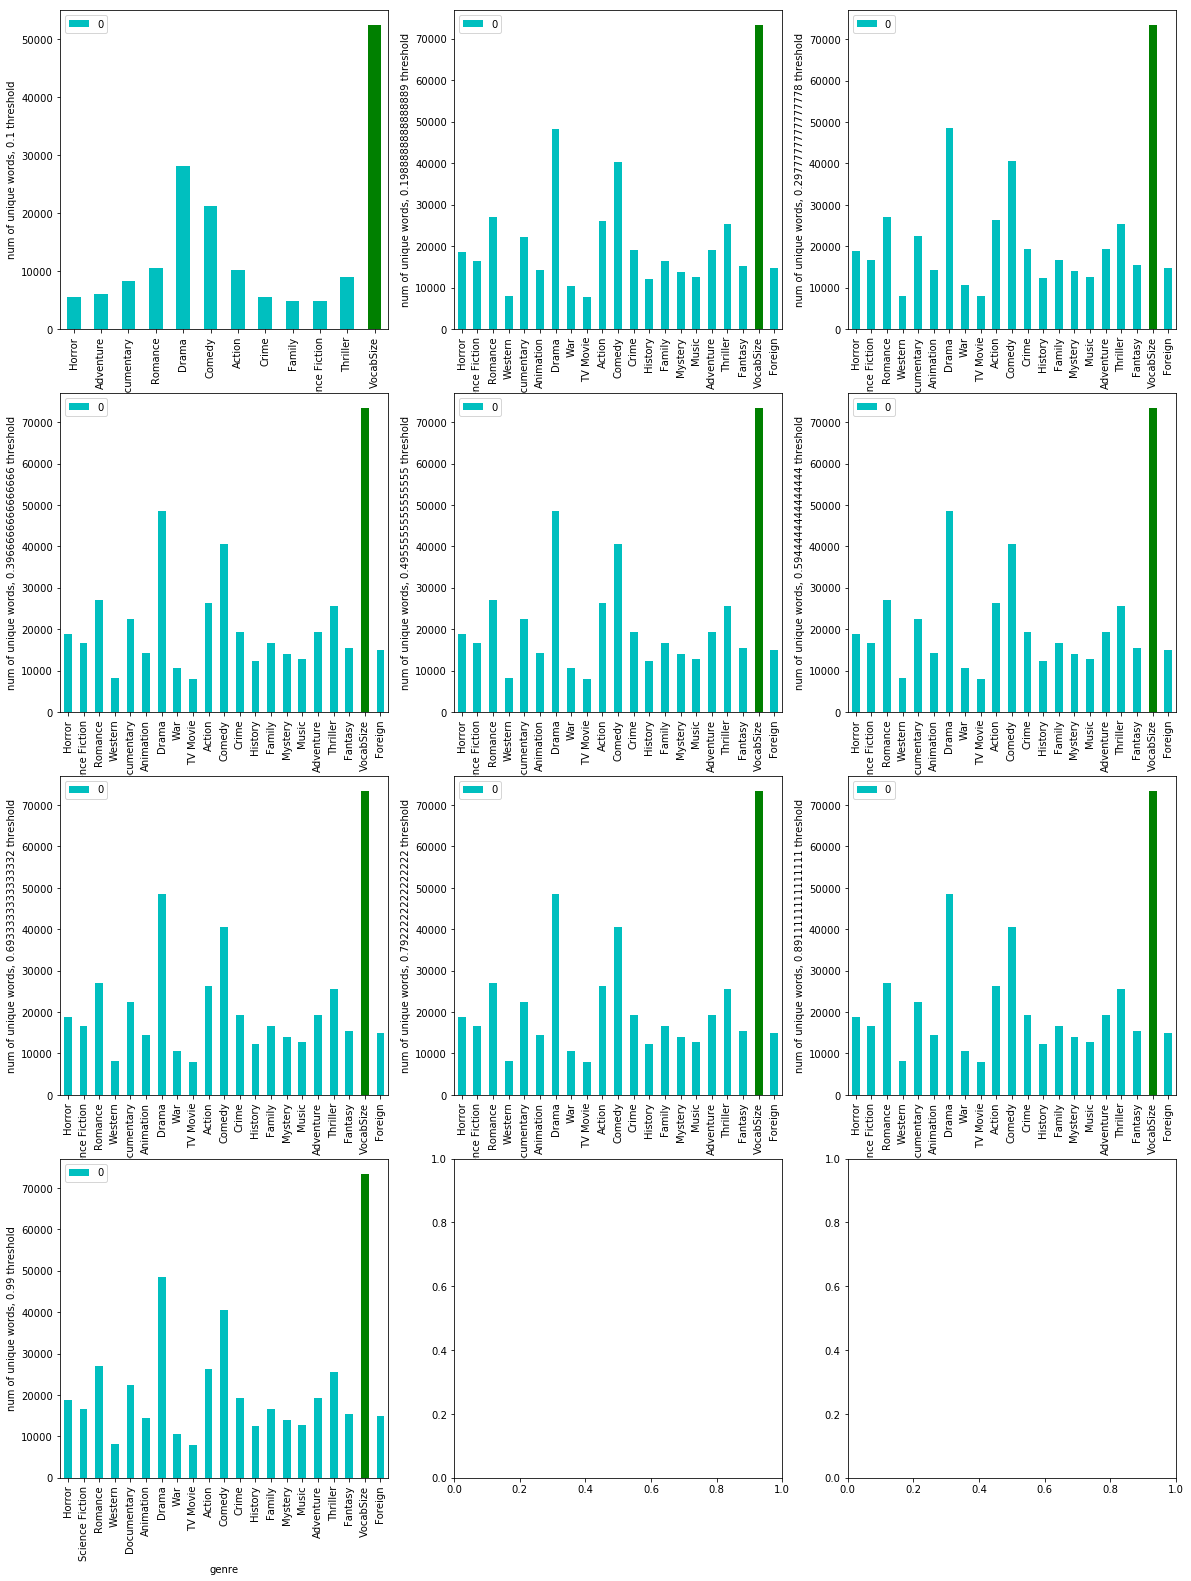

In [12]:
max_figs_in_row = 3
rows = int(np.ceil(len(plots_list)/max_figs_in_row))
cols  = np.minimum(len(plots_list),max_figs_in_row)

fig, axes = plt.subplots(rows, cols, figsize = (5*rows,9*cols))
for i, ax in enumerate(fig.axes):
    if i >= len(plots_list):
        continue
#     plots_list[i].plot(kind='bar',ax = ax)
    s = ['g' if index == 'VocabSize' else 'c' for index,value in plots_list[i][0].iteritems()]
    plots_list[i].plot(kind='bar',ax = ax,color = s)
    ax.set_xlabel("genre")
    ax.set_ylabel("num of unique words, {} threshold".format(thresholds[i]))

In [13]:
overview_cleaned = myTfIdfGenerator.getCleanedDocuments(list(movies_df_clean['overview']), threshold = 0.5)
movies_df_clean['overview_cleaned'] = overview_cleaned

# All genres have similar sentiments

In [14]:
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

In [123]:
class Utils:
    
    @staticmethod
    def getGenres(genresStr):
        if pd.isnull(genresStr ):
            return []
        
        genresInStrList = []
        genreJson = json.loads(genresStr.replace("'",'"'))
        for genreObject in genreJson:
            genreName = genreObject['name'].lower()
            genresInStrList.append(genreName)
        
        return genresInStrList

In [124]:
class LabeledIMDBData:
    
    def __init__(self,df):
        self.df = df
        self.tokenizer = PreprocessIMDBData()
        self.to_array()
    
    def __iter__(self):
        for movie_data in self.movies:
            yield movie_data
    
    def to_array(self):
        self.movies = []
        for index,row in self.df.iterrows():
            movietags = Utils.getGenres( row['genres'])
            movietags.append(row['id'])
            movietags.append(row['title'])
            self.movies.append(TaggedDocument(words = self.tokenizer.tokenizeSentence(row['overview_cleaned']),
                                              tags = movietags))
        return self.movies
    
    def generate_permutations(self):
        from random import shuffle
        shuffle(self.movies)
        return self
    
    def datasetSize(self):
        return len(self.movies)
    
    def getVocabFreq(self):
        vocab = {}
        for movie_info in self:
            overview = movie_info.words
            for word in overview:
                freq = 0
                if word in vocab:
                    freq = vocab[word]
                freq = freq + 1
                vocab[word] = freq
            
            tags = movie_info.tags
            for tag in tags:
                freq = 0
                if tag in vocab:
                    freq = vocab[tag]
                freq = freq + 1
                vocab[tag] =  freq
        return vocab

In [146]:
cores = 1
simple_models = [
    # PV-DM w/ concatenation - window=5 (both sides) approximates paper's 10-word total window size
    Doc2Vec(dm=1, dm_concat=1, size=100, window=5, negative=5, hs=0, min_count=2, workers=cores),
    # PV-DBOW 
    Doc2Vec(dm=0, size=100, negative=5, hs=0, min_count=2, workers=cores),
    # PV-DM w/ average
    Doc2Vec(dm=1, dm_mean=1, size=100, window=10, negative=5, hs=0, min_count=2, workers=cores),
]

In [147]:
movies_df_clean.head()

,id,title,genres,overview,overview_cleaned
0,862,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","Led by Woody, Andy's toys live happily in his ...",put eventually buzz heart learns woody live se...
1,8844,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",When siblings Judy and Peter discover an encha...,three enchanted running risky evil living prov...
2,15602,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",A family wedding reignites the ancient feud be...,bait reignites hot fish seafood divorcée weddi...
3,31357,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","Cheated on, mistreated and stepped on, the wom...",cheated lovers talk break breathe women glo fr...
4,11862,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",Just when George Banks has recovered from his ...,arrival wedding nina banks planning pregnant l...


In [148]:
movies_data = LabeledIMDBData(movies_df_clean.head())  ## Small dataset
# movies_data = LabeledIMDBData(movies_df_clean)
model = simple_models[1]
# model.delete_temporary_training_data()
model.build_vocab_from_freq(movies_data.getVocabFreq())
# model.build_vocab(movies_data.to_array())
model.raw_vocab

defaultdict(int, {})

In [149]:
movies_data.to_array()

[TaggedDocument(words=['put', 'eventually', 'buzz', 'heart', 'learns', 'woody', 'live', 'separate', 'duo', 'losing', 'andy', 'place', 'toys', 'differences', 'circumstances', 'led', 'lightyear', 'plots', 'afraid', 'owner', 'scene', 'room', 'onto', 'aside', 'happily', 'birthday', 'brings'], tags=['animation', 'comedy', 'family', '862', 'Toy Story']),
 TaggedDocument(words=['three', 'enchanted', 'running', 'risky', 'evil', 'living', 'proves', 'unwittingly', 'freedom', 'game', 'hope', 'world', 'door', 'discover', 'find', 'creatures', 'inside', 'alan', 'opens', 'siblings', 'monkeys', 'giant', 'board', 'trapped', 'adult', 'magical', '26', 'rhinoceroses', 'room', 'terrifying', 'peter', 'invite', 'judy', 'finish', 'years'], tags=['adventure', 'fantasy', 'family', '8844', 'Jumanji']),
 TaggedDocument(words=['bait', 'reignites', 'hot', 'fish', 'seafood', 'divorcée', 'wedding', 'buddies', 'time', 'door', 'less', 'locals', 'neighbors', 'sultry', 'opens', 'restaurant', 'scare', 'john', 'cooking', '

In [150]:
alpha, min_alpha, passes = (0.025, 0.001, 20)
alpha_delta = (alpha - min_alpha) / passes

for epoch in range(passes):
    print("Now at epoch number ",(epoch+1)," out of total number of epoch ",passes)
    
    model.alpha, model.min_alpha = alpha, alpha
    model.train(movies_data.generate_permutations(), total_examples=movies_data.datasetSize(), epochs=1)
    model.alpha -= alpha_delta
    print(model.corpus_count)
    
    print("Done with epoch ")

Now at epoch number  1  out of total number of epoch  20
0
Done with epoch 
Now at epoch number  2  out of total number of epoch  20
0
Done with epoch 
Now at epoch number  3  out of total number of epoch  20
0
Done with epoch 
Now at epoch number  4  out of total number of epoch  20
0
Done with epoch 
Now at epoch number  5  out of total number of epoch  20
0
Done with epoch 
Now at epoch number  6  out of total number of epoch  20
0
Done with epoch 
Now at epoch number  7  out of total number of epoch  20
0
Done with epoch 
Now at epoch number  8  out of total number of epoch  20
0
Done with epoch 
Now at epoch number  9  out of total number of epoch  20
0
Done with epoch 
Now at epoch number  10  out of total number of epoch  20
0
Done with epoch 
Now at epoch number  11  out of total number of epoch  20
0
Done with epoch 
Now at epoch number  12  out of total number of epoch  20
0
Done with epoch 
Now at epoch number  13  out of total number of epoch  20
0
Done with epoch 
Now at e

In [132]:
list(model.docvecs)

[]

In [122]:
model.save('./models/imdb.d2v')
model.save_word2vec_format('./models/word2vecformat.nn')

In [105]:
doc_id = 862
sims = model.docvecs.most_similar(doc_id, topn=model.docvecs.count)  # get *all* similar documents
print(u'TARGET (%d): «%s»\n' % (doc_id, ' '.join(alldocs[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(alldocs[sims[index][0]].words)))

KeyError: "doc '862' not in trained set"

In [52]:
model.most_similar('animation')

KeyError: "word 'animation' not in vocabulary"

In [40]:
model.most_similar('comedy')

[('2024', 0.4037773013114929),
 ('ideologies', 0.39514151215553284),
 ('malkovich', 0.3804531395435333),
 ('stoners', 0.3733907639980316),
 ('mistaken', 0.3675557076931),
 ('glossy', 0.35141468048095703),
 ('blockade', 0.35096532106399536),
 ('bona', 0.3508034646511078),
 ('alas', 0.34684640169143677),
 ('vietnamese', 0.342284619808197)]

In [41]:
model.most_similar(['grumpier','old','men'])

KeyError: "word 'grumpier' not in vocabulary"

In [43]:
model.docvecs.similarity('romance','animation')

KeyError: 'romance'

In [106]:
model.docvecs.similarity('drama','family')

KeyError: 'drama'

In [110]:
from collections import namedtuple

SentimentDocument = namedtuple('SentimentDocument', 'words tags')

In [112]:
words = list(movies_data.getVocabFreq().keys())
tags = list(movies_data.getVocabFreq().keys())[:5]
SentimentDocument(words, tags)

SentimentDocument(words=['grumpier old men', 'father of the bride part ii', 'board', 'three', 'drama', 'arrival', 'nina', 'put', 'differences', '862', 'jumanji', 'reignites', 'man', 'living', '31357', 'unwittingly', 'cheated', 'place', 'stellar', 'freedom', 'hope', 'change', 'woody', 'risky', 'world', 'women', 'fish', 'time', 'invite', 'wedding', 'buddies', 'andy', 'expecting', 'less', 'like', 'home', 'inside', 'better', 'alan', 'talk', 'creatures', 'scare', 'news', 'animation', 'running', 'giant', 'banks', 'seafood', 'robin', 'confidants', 'trapped', 'cooking', '15602', 'eventually', 'max', 'meanwhile', 'toy story', 'scene', 'waiting to exhale', 'local', '8844', 'pregnant', 'receives', 'selling', 'sultry', 'plan', 'onto', 'interested', 'italian', 'birthday', 'worry', 'heart', 'judy', 'finish', '26', 'terrifying', 'afraid', 'restaurant', 'enchanted', 'lovers', 'bait', 'planning', 'peter', 'learns', 'break', 'evil', 'buzz', 'proves', 'waiting', 'hot', 'wife', 'romance', 'fantasy', 'led'

In [113]:
TaggedDocument(words = words, tags = tags)

TaggedDocument(words=['grumpier old men', 'father of the bride part ii', 'board', 'three', 'drama', 'arrival', 'nina', 'put', 'differences', '862', 'jumanji', 'reignites', 'man', 'living', '31357', 'unwittingly', 'cheated', 'place', 'stellar', 'freedom', 'hope', 'change', 'woody', 'risky', 'world', 'women', 'fish', 'time', 'invite', 'wedding', 'buddies', 'andy', 'expecting', 'less', 'like', 'home', 'inside', 'better', 'alan', 'talk', 'creatures', 'scare', 'news', 'animation', 'running', 'giant', 'banks', 'seafood', 'robin', 'confidants', 'trapped', 'cooking', '15602', 'eventually', 'max', 'meanwhile', 'toy story', 'scene', 'waiting to exhale', 'local', '8844', 'pregnant', 'receives', 'selling', 'sultry', 'plan', 'onto', 'interested', 'italian', 'birthday', 'worry', 'heart', 'judy', 'finish', '26', 'terrifying', 'afraid', 'restaurant', 'enchanted', 'lovers', 'bait', 'planning', 'peter', 'learns', 'break', 'evil', 'buzz', 'proves', 'waiting', 'hot', 'wife', 'romance', 'fantasy', 'led', '

In [114]:
movies_data.to_array()

[TaggedDocument(words=['put', 'eventually', 'buzz', 'heart', 'learns', 'woody', 'live', 'separate', 'duo', 'losing', 'andy', 'place', 'toys', 'differences', 'circumstances', 'led', 'lightyear', 'plots', 'afraid', 'owner', 'scene', 'room', 'onto', 'aside', 'happily', 'birthday', 'brings'], tags=['Animation', 'Comedy', 'Family', '862', 'Toy Story']),
 TaggedDocument(words=['three', 'enchanted', 'running', 'risky', 'evil', 'living', 'proves', 'unwittingly', 'freedom', 'game', 'hope', 'world', 'door', 'discover', 'find', 'creatures', 'inside', 'alan', 'opens', 'siblings', 'monkeys', 'giant', 'board', 'trapped', 'adult', 'magical', '26', 'rhinoceroses', 'room', 'terrifying', 'peter', 'invite', 'judy', 'finish', 'years'], tags=['Adventure', 'Fantasy', 'Family', '8844', 'Jumanji']),
 TaggedDocument(words=['bait', 'reignites', 'hot', 'fish', 'seafood', 'divorcée', 'wedding', 'buddies', 'time', 'door', 'less', 'locals', 'neighbors', 'sultry', 'opens', 'restaurant', 'scare', 'john', 'cooking', '